In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt

In [2]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn import metrics
from sklearn.metrics import precision_recall_fscore_support, roc_auc_score, accuracy_score, recall_score, balanced_accuracy_score, roc_curve
from sklearn.utils import shuffle
from sklearn.datasets import make_classification
from sklearn.neighbors import NearestNeighbors
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import LabelEncoder

from imblearn.over_sampling import SMOTE

# Reading, Preprocessing and EDA

In [3]:
Train_path = "../datasets/CreditCard/UCI_Credit_Card.csv"
train_df = pd.read_csv(Train_path)
print("Done")

Done


Dataset has no missing or categorical values.

In [4]:
print(train_df.isnull().sum().sum(), train_df.isna().sum().sum())

0 0


In [5]:
list_dtype = [train_df[i].dtype for i in train_df.columns]
print(dict((i, list_dtype.count(i)) for i in list_dtype))

{dtype('int64'): 12, dtype('float64'): 13}


In [6]:
label_encoder = LabelEncoder()
pred_var = train_df.columns[-1]
train_df[pred_var] = label_encoder.fit_transform(train_df[pred_var])    

In [7]:
print(train_df[pred_var].value_counts())

0    23364
1     6636
Name: default.payment.next.month, dtype: int64


In [8]:
from sklearn.preprocessing import StandardScaler
scl = StandardScaler()
scl.fit(train_df)
scl.transform(train_df)
train_df, test_df = train_test_split(train_df, train_size = 0.9, random_state = 42) 
y_train = train_df[pred_var]
y_test = test_df[pred_var]
X_train = train_df.drop([pred_var], axis = 1)
X_test = test_df.drop([pred_var], axis = 1)

In [9]:
class CentroidSMOTE():
    def __init__(self, sampling_strategy='auto', random_state=42, k_neighbors=5, m_vertices=3):
        self.sampling_strategy = sampling_strategy
        self.random_state = random_state
        self.k_neighbors = k_neighbors
        self.m_vertices = m_vertices
    
    @staticmethod
    def nearest_neighbor(X, k):
        from sklearn.neighbors import NearestNeighbors
        nbs=NearestNeighbors(n_neighbors=k+1,metric='euclidean',algorithm='kd_tree').fit(X)
        euclidean,indices= nbs.kneighbors(X)
        return indices[:, 1:]
    
    def fit_resample(self, X, y):
        
        (unique, freq) = np.unique(y, return_counts=True)
        frequency = dict(zip(unique, freq))
        max_frequency = max(frequency.values())
        
        if self.sampling_strategy == 'auto':
            sampling_strategy = {}
            for (key, value) in frequency.items():
                sampling_strategy[key] = max_frequency - value
            self.sampling_strategy = sampling_strategy
            
        data = {}
        for (key, value) in self.sampling_strategy.items():
            if value == 0:
                continue
            X_small = X[y == key]
            indices = self.nearest_neighbor(X_small, self.k_neighbors)
            new_data = []
            for idx in np.random.choice(np.arange(len(X_small)), size=value):
                p = X_small[idx]
                nnarray = indices[idx]
                q = X_small[np.random.choice(nnarray, size=self.m_vertices-1, replace=False)]
                new_data.append(np.sum(np.vstack([p, q]), axis=0)/self.m_vertices)
            X_new = np.vstack(new_data)
            data[key] = X_new
        
        for (key, value) in data.items():
            X = np.vstack([X, value])
            y = np.concatenate([y, np.ones(len(value))*key])
        
        X, y = shuffle(X, y, random_state=self.random_state)
        
        return X, y        

In [10]:
def score(X_test, y_test, model):
    y_pred = model.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    
    print(f"Accuracy: {acc:.6f}")
    print(f"Error Rate: {1-acc}")
    Recall = recall_score(y_test, y_pred, average='macro')      
    print(f"Mean Recall: {Recall}")
    print(f"Balanced Accuracy Score: {balanced_accuracy_score(y_test, y_pred)}")
    Array_prec_recall_f = precision_recall_fscore_support(y_test, y_pred, average='macro')
#                                                                         average = 'micro', 'macro', 'weighted'
    print(f"Precision: {Array_prec_recall_f[0]}")
    print(f"F-Score: {Array_prec_recall_f[2]}")
          
    
    TP = 0
    FP = 0
    TN = 0
    FN = 0
    print(len(y_pred), len(y_test))
    for i in range(len(y_pred)): 
        if y_test[i]==y_pred[i]==1:
           TP += 1
        if y_pred[i]==1 and y_test[i]!=y_pred[i]:
           FP += 1
        if y_test[i]==y_pred[i]==0:
           TN += 1
        if y_pred[i]==0 and y_test[i]!=y_pred[i]:
           FN += 1
    if TN + FP == 0: 
      Selectivity = 0
    else:
      Selectivity = TN/(TN + FP)
    G_mean = np.sqrt(Selectivity*Recall) 
    print(f"Selectivity: {Selectivity}") 
    print(f"G_mean: {G_mean}")   
    
    
    confusion_matrix = metrics.confusion_matrix(y_test, y_pred)

    cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [False, True])

    cm_display.plot()
    plt.show()
    
    
    fpr, tpr, thresholds = roc_curve(y_test, y_pred)
    plt.plot(fpr, tpr)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
   
        

In [11]:
pipeline = Pipeline([
    ('classifier', KNeighborsClassifier(metric='euclidean'))
])

parameters = {
    'classifier__n_neighbors' : [3, 5, 7, 9, 11],
}

In [12]:
y_test = y_test.to_numpy()
y_train = y_train.to_numpy()
X_train = X_train.to_numpy()
X_test = X_test.to_numpy()

Fitting 5 folds for each of 5 candidates, totalling 25 fits
Accuracy: 0.768333
Error Rate: 0.2316666666666667
Mean Recall: 0.5413737044789103
Balanced Accuracy Score: 0.5413737044789103
Precision: 0.6061422413793104
F-Score: 0.5350522648083623
3000 3000
Selectivity: 0.9461768475010679
G_mean: 0.7157061303522767


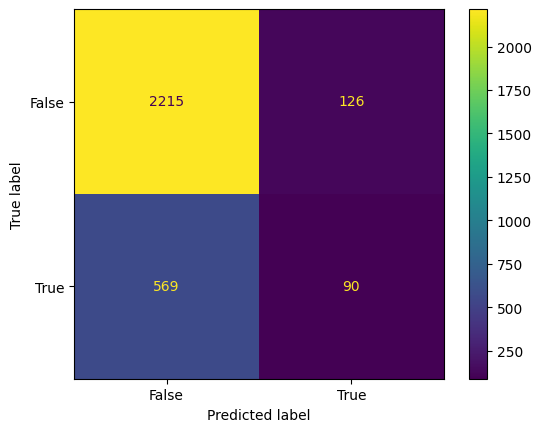

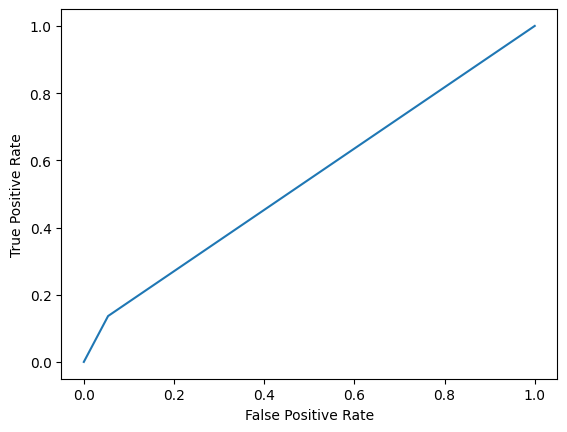

In [13]:
clf = GridSearchCV(pipeline, param_grid = parameters, cv = 5, verbose=True, n_jobs=-1)
best_clf = clf.fit(X_train, y_train)
score(X_test, y_test, best_clf)

Resampled dataset shape Counter({0: 21023, 1: 21023})
Fitting 5 folds for each of 5 candidates, totalling 25 fits
Accuracy: 0.606667
Error Rate: 0.3933333333333333
Mean Recall: 0.5675291482116964
Balanced Accuracy Score: 0.5675291482116964
Precision: 0.5485528769322044
F-Score: 0.5369585554362635
3000 3000
Selectivity: 0.6373344724476719
G_mean: 0.6014198951433002


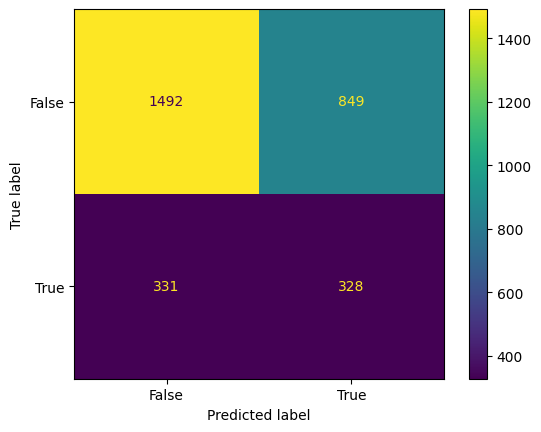

Resampled dataset shape Counter({0: 21023, 1: 21023})
Fitting 5 folds for each of 5 candidates, totalling 25 fits
Accuracy: 0.604000
Error Rate: 0.396
Mean Recall: 0.5685461837184866
Balanced Accuracy Score: 0.5685461837184866
Precision: 0.5490258347917801
F-Score: 0.5363410281988956
3000 3000
Selectivity: 0.6317812900469885
G_mean: 0.5993303274496942


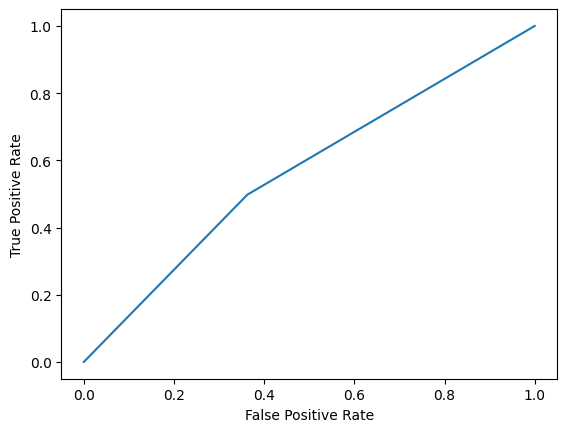

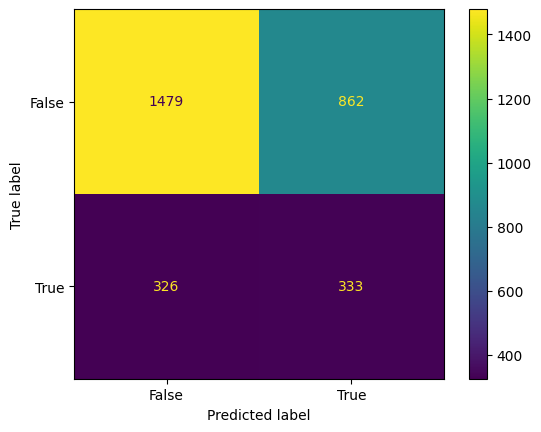

Resampled dataset shape Counter({0: 21023, 1: 21023})
Fitting 5 folds for each of 5 candidates, totalling 25 fits
Accuracy: 0.611667
Error Rate: 0.3883333333333333
Mean Recall: 0.5740037557066452
Balanced Accuracy Score: 0.5740037557066452
Precision: 0.5532563893486289
F-Score: 0.5424261312777465
3000 3000
Selectivity: 0.6411789833404528
G_mean: 0.6066622985793565


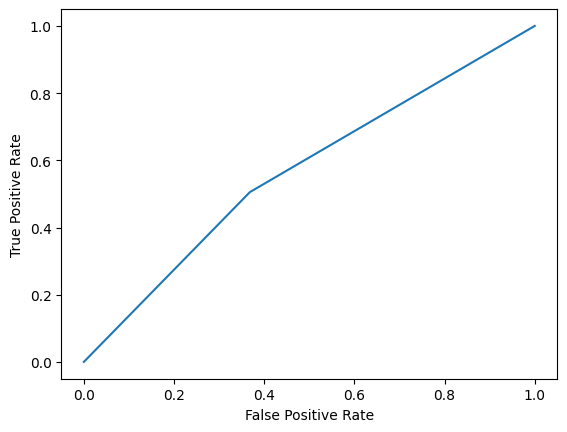

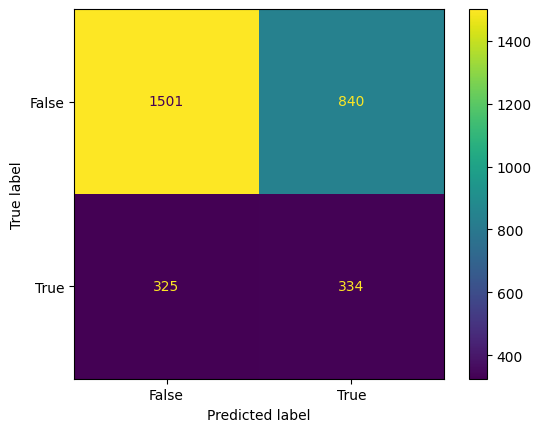

Resampled dataset shape Counter({0: 21023, 1: 21023})
Fitting 5 folds for each of 5 candidates, totalling 25 fits
Accuracy: 0.604667
Error Rate: 0.3953333333333333
Mean Recall: 0.5651573617748922
Balanced Accuracy Score: 0.5651573617748922
Precision: 0.5468194781549158
F-Score: 0.5348871258115945
3000 3000
Selectivity: 0.6356258009397693
G_mean: 0.5993568225482819


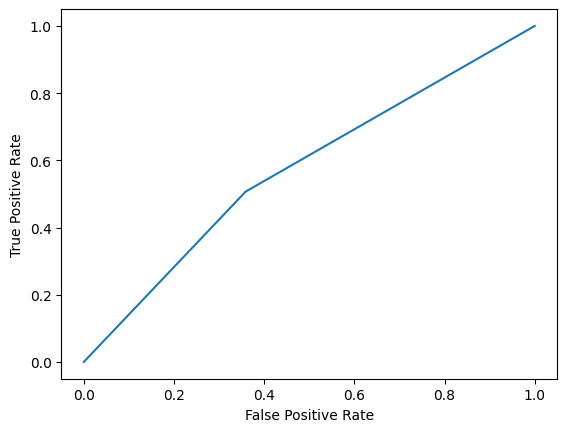

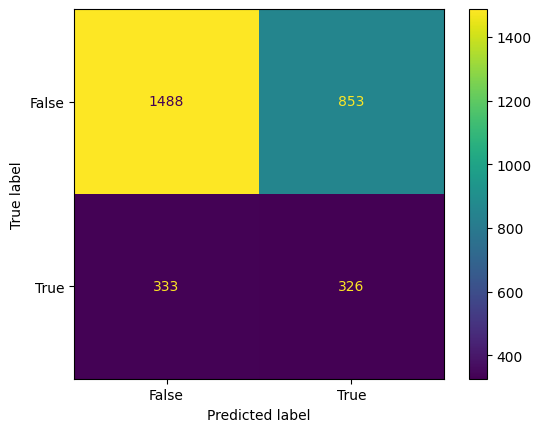

Resampled dataset shape Counter({0: 21023, 1: 21023})
Fitting 5 folds for each of 5 candidates, totalling 25 fits
Accuracy: 0.609667
Error Rate: 0.3903333333333333
Mean Recall: 0.5710868278669026
Balanced Accuracy Score: 0.5710868278669026
Precision: 0.5511572385251087
F-Score: 0.5400695276620096
3000 3000
Selectivity: 0.6398974797095258
G_mean: 0.6045138723365566


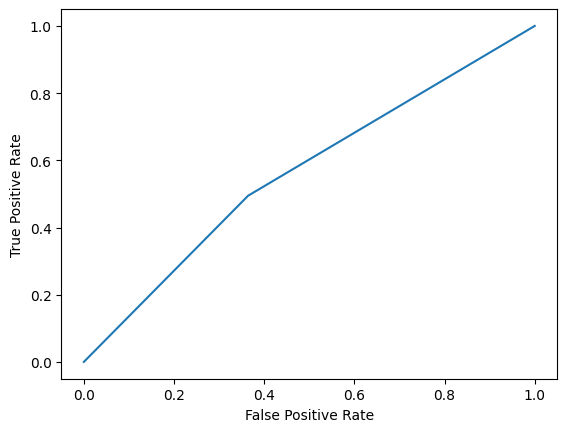

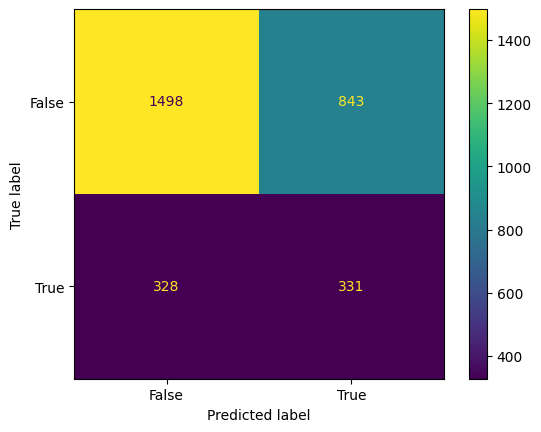

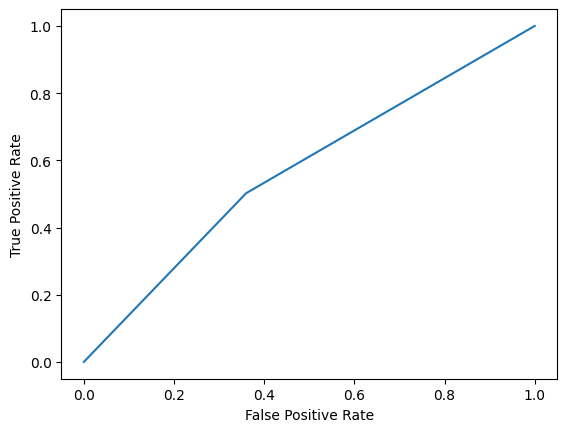

In [14]:
sm_list = []
from collections import Counter
for i in [3, 5, 7, 9, 11]:
    sm_list.append(SMOTE(random_state=42, k_neighbors=i))
for sm in sm_list:
    X_new, y_new = sm.fit_resample(X_train, y_train)
    print('Resampled dataset shape %s' % Counter(y_new))
    pipeline = Pipeline([
        ('classifier', KNeighborsClassifier())
    ])

    parameters = {
        'classifier__n_neighbors' : [3, 5, 7, 9, 11],
    }

    clf = GridSearchCV(pipeline, param_grid = parameters, cv = 5, verbose=True, n_jobs=-1)
    best_clf = clf.fit(X_new, y_new)
    score(X_test, y_test, best_clf)

Fitting 5 folds for each of 5 candidates, totalling 25 fits
Accuracy: 0.617000
Error Rate: 0.383
Mean Recall: 0.5752405331106961
Balanced Accuracy Score: 0.5752405331106961
Precision: 0.5545593419506463
F-Score: 0.5453417712202528
3000 3000
Selectivity: 0.6497223408799658
G_mean: 0.6113482033520021


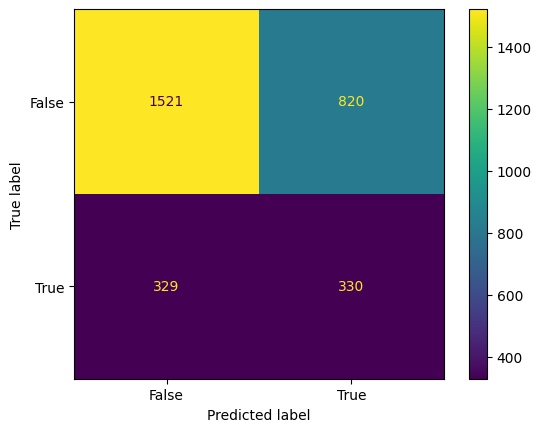

Fitting 5 folds for each of 5 candidates, totalling 25 fits
Accuracy: 0.619000
Error Rate: 0.381
Mean Recall: 0.5825185921739474
Balanced Accuracy Score: 0.5825185921739474
Precision: 0.5595306680932491
F-Score: 0.5499630875235829
3000 3000
Selectivity: 0.6475865014950876
G_mean: 0.614191482488784


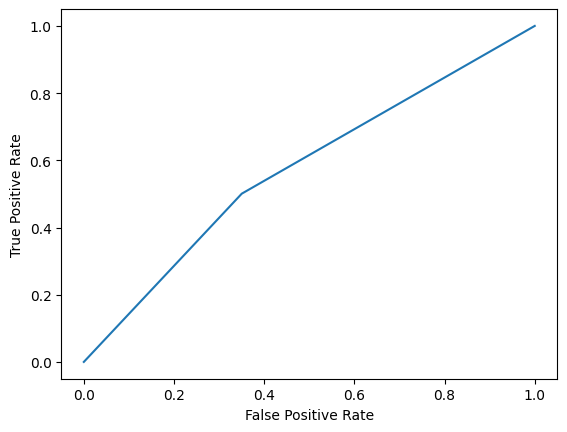

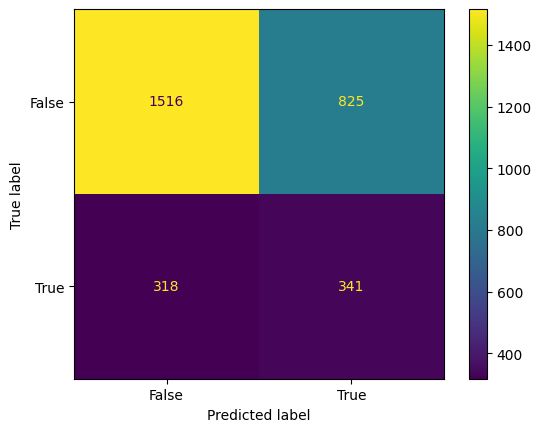

Fitting 5 folds for each of 5 candidates, totalling 25 fits
Accuracy: 0.607667
Error Rate: 0.3923333333333333
Mean Recall: 0.5774373038771157
Balanced Accuracy Score: 0.5774373038771157
Precision: 0.555186406102176
F-Score: 0.5423979152732439
3000 3000
Selectivity: 0.6313541221700129
G_mean: 0.6037941885258216


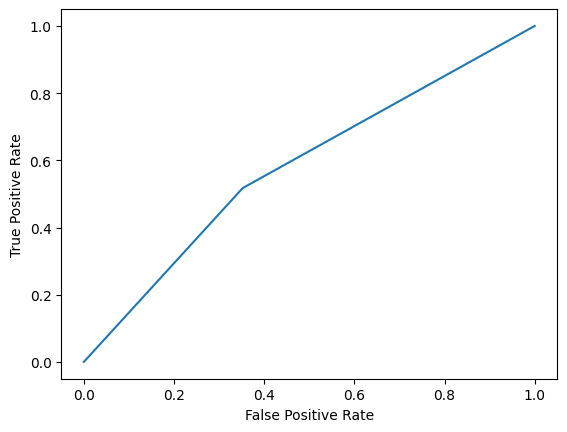

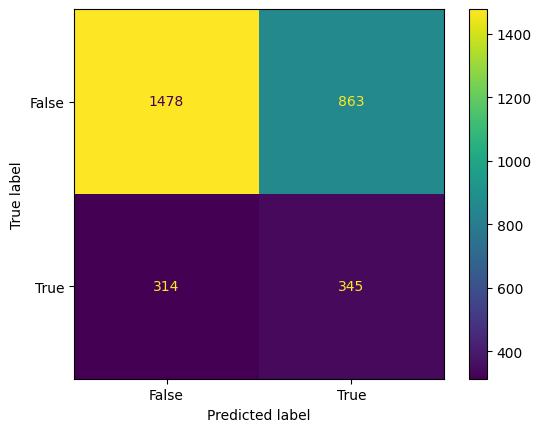

Fitting 5 folds for each of 5 candidates, totalling 25 fits
Accuracy: 0.616333
Error Rate: 0.3836666666666667
Mean Recall: 0.5742682238307819
Balanced Accuracy Score: 0.5742682238307819
Precision: 0.5538542890716804
F-Score: 0.5445503730848661
3000 3000
Selectivity: 0.6492951730029902
G_mean: 0.6106304821594869


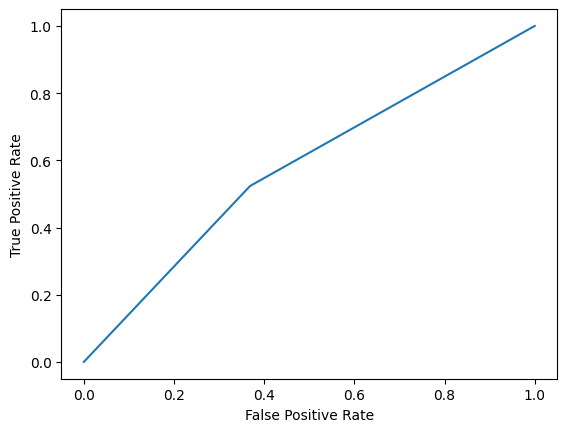

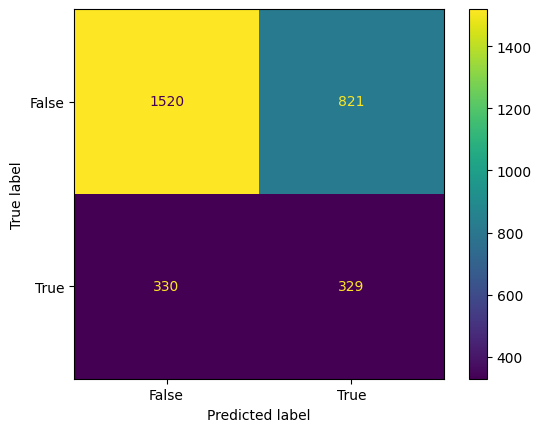

Fitting 5 folds for each of 5 candidates, totalling 25 fits
Accuracy: 0.617000
Error Rate: 0.383
Mean Recall: 0.5746953917077575
Balanced Accuracy Score: 0.5746953917077575
Precision: 0.5541998103566349
F-Score: 0.5450556577614865
3000 3000
Selectivity: 0.6501495087569414
G_mean: 0.6112592957196451


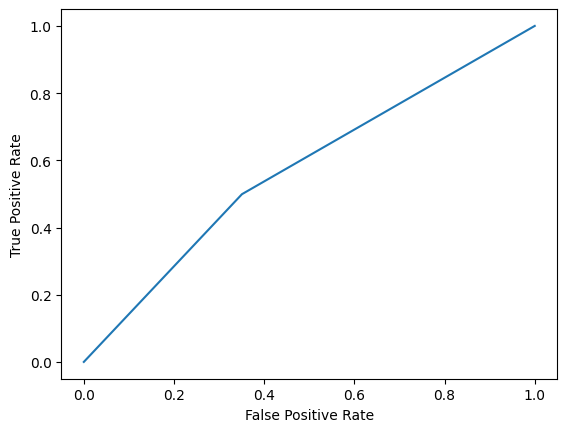

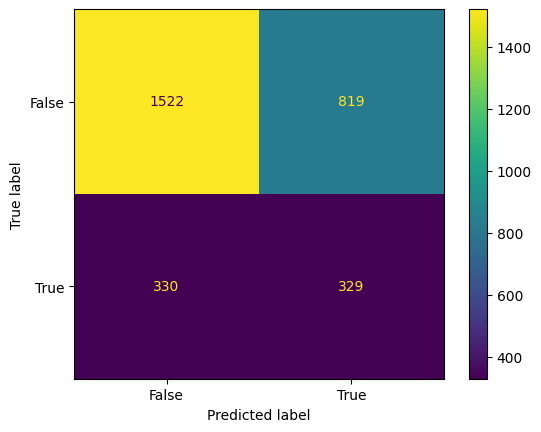

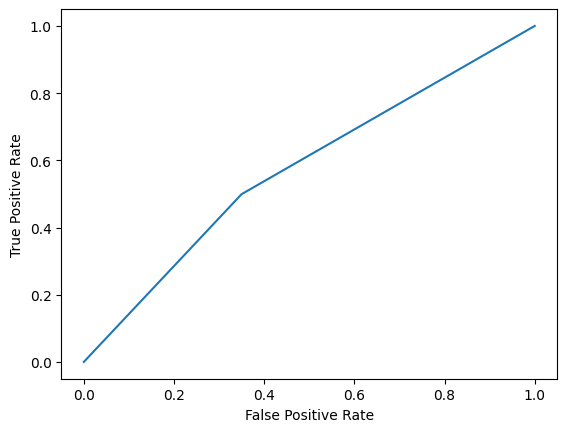

In [15]:
csm_list = []
for (i,j) in [(5,3), (7,3), (9,3), (7,5), (9,7)]:
    csm_list.append(CentroidSMOTE(k_neighbors=i, m_vertices=j))

for csm in csm_list:
    X_new, y_new = csm.fit_resample(X_train, y_train)
    pipeline = Pipeline([
        ('classifier', KNeighborsClassifier())
    ])

    parameters = {
        'classifier__n_neighbors' : [3, 5, 7, 9, 11],
    }

    clf = GridSearchCV(pipeline, param_grid = parameters, cv = 5, verbose=True, n_jobs=-1)
    best_clf = clf.fit(X_new, y_new)
    score(X_test, y_test, best_clf)